# ALBERT: 
(A Lite BERT For Self-Supervised learning of language Representations)

### 现存的问题：
虽然大模型带来的更佳的效果，但大模型的训练更难：
* GPU 内存不足
* 训练时间更长
  
*本文带来了2种成功的参数量减少方法*

### 背景：
* 无数ai模型已经证明大模型（大参数量）对network的表现十分重要
* 预训练大模型 + 将大模型提取为小模型的训练方式被广泛认可   

   *但larger==better吗？*
   #### 大模型训练存在的问题：
  * 大模型受到硬件内存的限制
  * 分布式训练会降低训练速度
   #### 已有的解决方法：
  1. 模型并行（model parallelization）将一个模型分割到不同的GPU上（注：与Data Parallel不同）
  2. 更clever的内存管理（memory management）   
   **（这些解决方法解决了内存的限制，但存在交互开销（communication overhead））**

<style>
p{
  line-height = 1.8
}
</style>
### ALBERT 带来的解决方法：
* **矩阵分解（factorized embedding parameterization）**：
  * <p>方法：V * H 的矩阵可以分解为 V * E AND E * H</p>
  * 优点：
    * <p>在 E << H时，参数量下降非常明显</p>
    * <p>在不显著增加参数的条件下，提高隐藏层的大小</p>
  
* **跨层参数共享（cross-layer parameter sharing）**：
  * <p>方法：不同层共享相同参数 </p>
  * 优点：
    * <p>参数量不因深度而改变</p>
* **自监督损失函数（self—supervised loss）**：
  * <p>优点：用于 句子顺序预测（SOP：sentence order prediction），用于解决原版 BERT中下一句预测（NSP）损失的低效问题</p>

### 具体解释 & 模型实现：
* 实现矩阵分解：
  * 从建模的角度来说，WordPiece 词嵌入的目标是学习上下文无关的表示，而隐藏层嵌入的目标是学习上下文相关的表示。通过上下文长度相关的实验表明，BERT的表征能力很大一部分来自于使用上下文以在学习过程提供上下文相关的表征信息。因此，将 WordPiece 词嵌入大小 E 从隐藏层大小 H 分离出来，可以更高效地利用总体的模型参数， 其中 H 远远大于 E
  * 从实践的角度，自然语言处理使用的词典大小 V 一般非常庞大，如果 E 恒等于 H ，那么增加 H 将直接增大词典嵌入矩阵的大小(V * E)。这会导致模型参数剧增，而模型训练过程中大部分参数的更新是很稀疏的

    因此，本文所提出的ALBERT对词嵌入参数进行了因式分解，将其分解为两个小矩阵。本文不再将独热向量直接映射到大小为 H 的隐藏空间，而是先将它们映射到一个低维词嵌入空间 E ，然后再映射到隐藏空间。通过这种分解，可以将词嵌入参数降低。这在 H 远远大于 E 的时候，参数量减少得非常明显。
* 层间参数共享：
  * 论文中提到每一层输入与输出嵌入矩阵间的 L2 距离与余弦相似性：  
  * 图示：   
  
  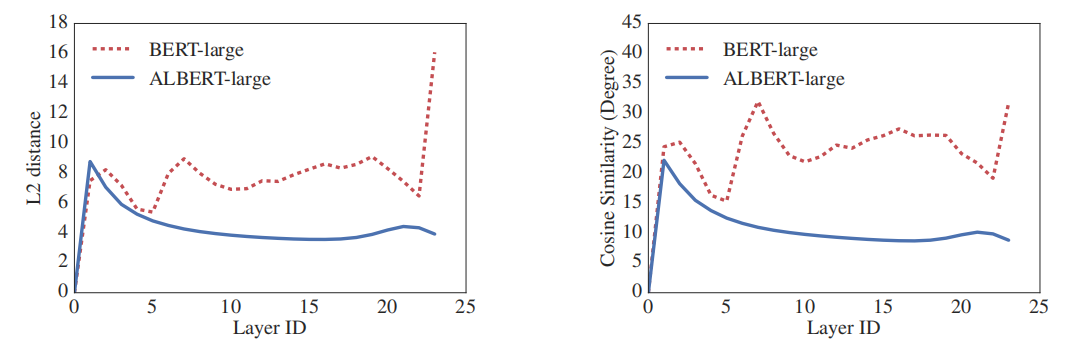  

  *（从图中可以发现 ALBERT 从一层到另一层的转换要比 BERT 平滑得多。这说明权重共享有效地提升了神经网络参数的鲁棒性。尽管相比于 BERT，ALBERT在两个评价指标都有所下降，但在 24 层以后，它们也不会收敛到 0）*

* 关于 SOP：   
  
  除了语言建模损失外，BERT 还使用了下一句预测损失(NSP)。NSP损失本是为了提升下游任务的性能，但是后来很多研究 (Yang et al., 2019; Liu et al.,2019)发现这种机制并不是很高效，因此决定去除它。

  据此我们猜测，NSP低效的原因，主要是它的难度太小。因为下一句预测将主题预测和连贯性预测结合到同一任务中，然而主题预测比连贯性预测简单得多，同时NSP与MLM损失函数学到的内容是有重合的。

  由于句间建模在语言理解中非常重要，因此本文提出一种基于语言连贯性的损失函数。在ALBERT中本文使用了一个句子次序预测（SOP）损失函数，它会避免预测主题，而只关注建模句子之间的连贯性。SOP正样本获取方法与BERT相同，而负样本仅仅是将正样本的两个部分次序对换。实验结果表明SOP能够在合理范围内解决NSP任务。在使用了该损失函数后，ALBERT能显著提升下游多句子编码任务的性能。

### 主要实验结果：
ALBERT的模型参数量远远小于对应的BERT模型。例如，ALBERT-large的参数量仅为BERT-large的1/18，即18M vs 334M。对于ALBERT-xxlarge，由于24层网络结构与12层网络结构在结果上接近，但是计算量更大，所以本文主要采用12层的网络结构。如：本文用到的BERT和ALBERT对应的超参数如下表：  

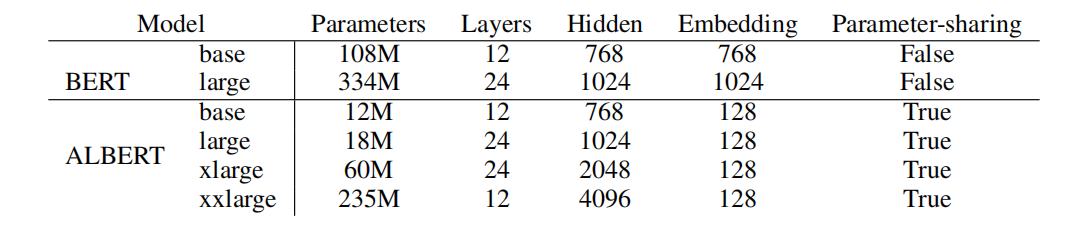